# Production constraints by timeslice

In some sectors it may be the case that a technology can only output a certain amount at a certain time. For instance, solar photovoltaics (PV) don't produce power in the dark, and thus their output is limited at night. 

In this section, we explain how to add constraints to outputs of technologies at certain timeslices. This could either by a maximum constraint, for instance with the solar PV example previously mentioned. Or, this could be a minimum constraint, where we expect a minimum amount of output by a nuclear power plant at all times.

## Minimum timeslice

In this tutorial we will be amending the default example, which you can find [here](https://github.com/SGIModel/MUSE_OS/tree/main/src/muse/data/example/default). Firstly, we will be imposing a minimium service factor for gasCCGT in the power sector. This is the minimum that a technology can output per timeslice. 

To do this, we will need to create a new `csv` file that specifies the minimum service factor per timeslice.

An example of the file can be seen below, and downloaded [here](https://github.com/SGIModel/MUSE_OS/blob/main/src/muse/data/example/default_timeslice/technodata/power/TechnodataTimeslices.csv).

|ProcessName|RegionName|Time|month|day|hour|UtilizationFactor|MinimumServiceFactor|
|-|-|-|-|-|-|-|-|
|Unit|-|Year|-|-|-|-|-|
|gasCCGT|R1|2020|all-year|all-week|night|1|1|
|gasCCGT|R1|2020|all-year|all-week|morning|1|2|
|gasCCGT|R1|2020|all-year|all-week|afternoon|1|3|
|gasCCGT|R1|2020|all-year|all-week|early-peak|1|2|
|gasCCGT|R1|2020|all-year|all-week|late-peak|1|5|
|gasCCGT|R1|2020|all-year|all-week|evening|1|6|
|windturbine|R1|2020|all-year|all-week|night|1|1|
|windturbine|R1|2020|all-year|all-week|morning|1|1|
|windturbine|R1|2020|all-year|all-week|afternoon|1|1|
|windturbine|R1|2020|all-year|all-week|early-peak|1|1|
|windturbine|R1|2020|all-year|all-week|late-peak|1|1|
|windturbine|R1|2020|all-year|all-week|evening|1|1|


Notice that we have to specify the following columns: `ProcessName`, `RegionName`, `Time`, `month`, `day`, `hour`, `UtilizationFactor`, `MinimumServiceFactor`

The majority of these columns are self explanatory, and correspond to the columns in other `csv` files - for instance, `ProcessName`, `RegionName` and `Time`. The timeslice based columns, however, are dynamic and will match the levels as defined in the `toml` file. 

The `UtilizationFactor` column specifies the maximum utilization factor for the respective technologies in the respective timeslices, and the `MinimumServiceFactor` specifies the minimum service factor of a technology.

Next, we must link this file to the `settings.toml` file. This is done by modifying the respective section. As we are modifying the power sector, we have to add it to the following section:

    [sectors.power]
    type = 'default'
    priority = 2
    dispatch_production = 'costed'

    technodata = '{path}/technodata/power/Technodata.csv'
    commodities_in = '{path}/technodata/power/CommIn.csv'
    commodities_out = '{path}/technodata/power/CommOut.csv'
    technodata_timeslices = '{path}/technodata/power/TechnodataTimeslices.csv'
    
Notice the technodata_timeslices path in the bottom row of the code above.

For the next part, we want to visualise the output of supply per technology, per timeslice. To do so, we will need to create our own output function. Creating our own output functions will be explored in later tutorials, so don't worry about understanding the code posted below for now.

Just copy and paste the code below into a python file called `output.py` and link to it in your `settings.toml` file as shown below:

    plugins = "{path}/output.py"

In [ ]:
from typing import List, Optional, Text

import xarray as xr

from muse.outputs.sector import register_output_quantity
from muse.outputs.sector import market_quantity


@register_output_quantity
def supply_timeslice(
    market: xr.Dataset,
    capacity: xr.DataArray,
    technologies: xr.Dataset,
    sum_over: Optional[List[Text]] = None,
    drop: Optional[List[Text]] = None,
    rounding: int = 4,
) -> xr.DataArray:
    """Current supply."""
    market = market.reset_index("timeslice")
    result = (
        market_quantity(market.supply, sum_over=sum_over, drop=drop)
        .rename("supply")
        .to_dataframe()
        .round(rounding)
    )
    return result[result.supply != 0]

To link to our new output `supply_timeslice` we must past the following code in our `settings.toml` file.

    [[sectors.power.outputs]]
    filename = '{cwd}/{default_output_dir}/{Sector}/{Quantity}/{year}{suffix}'
    quantity = "supply_timeslice"
    sink = "csv"
    overwrite = true

Once this has been completed, we are able to run MUSE as before, with the following command:

    python -m muse settings.toml

Next, we will visualise the output of the technologies as before. However, this time we will visualise the supply outputs that we created with the previous function per technology and per timeslice.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 10.0)

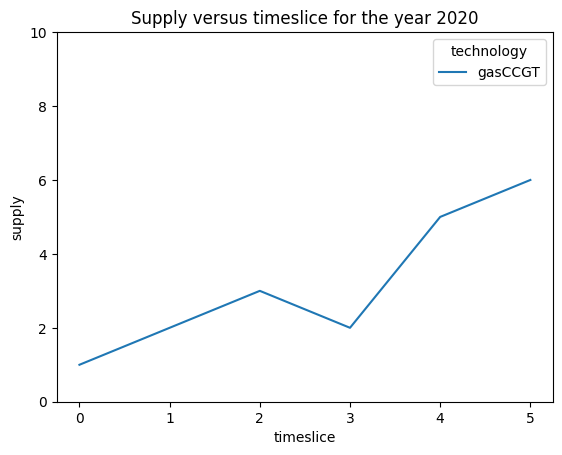

In [7]:
power_supply_2020 = pd.read_csv("../tutorial-code/7-min-max-timeslice-constraints/1-min-constraint/Results/Power/Supply_Timeslice/2020.csv")

sns.lineplot(data=power_supply_2020[(power_supply_2020.commodity=="electricity") & (power_supply_2020.year==2020) ], 
hue="technology", x="timeslice", y="supply")
plt.title("Supply versus timeslice for the year 2020")

plt.ylim(0,10)

As expected, for the year 2020, the gasCCGT supplies the electricity mix by the minimum per timeslice. This is as specified in the `TechnodataTimeslices.csv` file. Starting from a supply of 1 in the first timeslice and ending with a supply of 6 in the last timeslice. The supply increases linearly apart from during the 3rd timeslice, where it reduces to 2.

## Maximum timeslice constraint

Next, we want to ensure that the supply of `windturbine` does not exceed a certain value during the day. This may be because, for example, there is reduced wind during the day. We will, therefore, modify the `TechnodataTimeslices.csv` file by changing the values of `UtilizationFactor`.

|ProcessName|RegionName|Time|month|day|hour|UtilizationFactor|MinimumServiceFactor|
|-|-|-|-|-|-|-|-|
|Unit|-|Year|-|-|-|-|-|
|gasCCGT|R1|2020|all-year|all-week|night|1|1|
|gasCCGT|R1|2020|all-year|all-week|morning|1|2|
|gasCCGT|R1|2020|all-year|all-week|afternoon|1|3|
|gasCCGT|R1|2020|all-year|all-week|early-peak|1|2|
|gasCCGT|R1|2020|all-year|all-week|late-peak|1|5|
|gasCCGT|R1|2020|all-year|all-week|evening|1|6|
|windturbine|R1|2020|all-year|all-week|night|1|0|
|windturbine|R1|2020|all-year|all-week|morning|0.5|0|
|windturbine|R1|2020|all-year|all-week|afternoon|0.5|0|
|windturbine|R1|2020|all-year|all-week|early-peak|1|0|
|windturbine|R1|2020|all-year|all-week|late-peak|1|0|
|windturbine|R1|2020|all-year|all-week|evening|1|0|


Once this has been saved, we can run the model again (`python -m muse settings.toml`). Next, we can visualise our results as before. We should hopefully see a reduction in the output of `windturbine` to 0.5 in the 2nd and 3rd timeslices:

(0.0, 10.0)

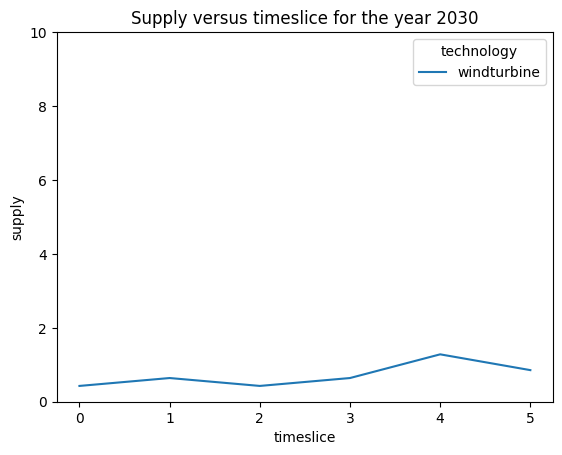

In [11]:
power_supply_2025 = pd.read_csv("../tutorial-code/7-min-max-timeslice-constraints/2-max-constraint/Results/Power/Supply_Timeslice/2025.csv")

sns.lineplot(data=power_supply_2025[(power_supply_2025.commodity=="electricity") & (power_supply_2025.year==2030)], 
x="timeslice", hue="technology", y="supply")
plt.title("Supply versus timeslice for the year 2030")

plt.ylim(0,10)

As expected, we can see an enforced reduction in `windturbine` output to 0.5 in the 2nd (1) and 3rd (2) timeslices.

## Next steps

This brings us to the end of the user guide! Using the information explained in this tutorial, or following similar steps, you will be able to create complex scenarios of your choosing.

For the full code to generate the final results, see [here](https://github.com/SGIModel/MUSE_OS/tree/main/docs/tutorial-code/7-min-max-timeslice-constraints/2-max-constraint).